Written by Joao Rodrigues

December 2020

Example: Implements a simple, spatially resolved, 2D harmonic oscillator. Calculates the mean-field time dynamics in both the real space molecular reservoir space, and in the rotated molecular basis. This shows the huge improvement in numerical performance approximating the cavity dynamics in an hierarchical manner, while retaining numerical accuracy.

Note: All parameters are defined in SI units

In [65]:
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt
import os
import sys
import time
sys.path.insert(0, os.path.abspath('..'))

## Calculates the cavity modes for a spherical mirror

In [66]:
grid_size = 12.0*1e-6      # meters
grid_delta = 0.25*1e-6      # meters 
L0 = 2.0*1e-6              # meters 
q = 10                     # longitudinal mode number
n = 1.43
n_modes = 10
feature_RoC = 100.0*1e-6   # meters
feature_depth = 0.279*1e-6 # meters

from PyPBEC.Cavity import Modes
cavity_modes = Modes(grid_size=grid_size, grid_delta=grid_delta, L0=L0, q=q, n=n, n_modes=n_modes)
cavity_modes.set_geometry_spherical(RoC=feature_RoC, depth=feature_depth)
lambdas, modes = cavity_modes.compute_cavity_modes()
g = cavity_modes.get_coupling_matrix()

## Defines the cavity pump profile

In [67]:
pump_width = 2.0*1e-6       # meters

X, Y = cavity_modes.get_cavity_grid()
pump_base = np.exp(-(X**2+Y**2) / pump_width**2)
pump = 1*(pump_base/np.sum(pump_base))
cavity_modes.load_pump(pump=pump)

## Plots the cavity modes and the pump profile

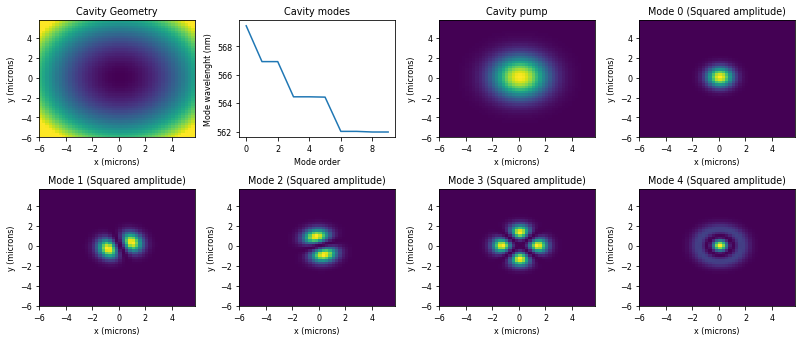

In [68]:
cavity_modes.plot_cavity()

## Calculates emission and absorption rates from experimental data

In [69]:
dye_concentration = 2.0               # in mM, with 1 mM=1mol/m^3

from PyPBEC.OpticalMedium import OpticalMedium
R6G = OpticalMedium(optical_medium="Rhodamine6G")
absorption_rates, emission_rates = R6G.get_rates(lambdas=lambdas, dye_concentration=dye_concentration, n=n)

### Normalizes the rates, for better numerical performance

In [70]:
cavity_loss_rate = 1.0/(10*1e-12)     # in s^-1

cavity_loss_rates = np.ones(n_modes)
emission_rates = emission_rates / cavity_loss_rate
absorption_rates = absorption_rates / cavity_loss_rate

## Defines a cavity

In [71]:
Gamma_down = 100.0

# Properties of the photonic modes
from PyPBEC.Cavity import Cavity
cavity = Cavity(M=n_modes, J=g.shape[1])
cavity.set_cavity_loss_rates(rates=cavity_loss_rates)
cavity.set_cavity_emission_rates(rates=emission_rates)
cavity.set_cavity_absorption_rates(rates=absorption_rates)

# Properties of the molecular modes
cavity.set_reservoir_decay_rates(rates=Gamma_down*np.ones(g.shape[1]))
cavity.set_reservoir_pump_rates(rates=np.reshape(pump, [pump.shape[0]*pump.shape[1]]))
molecular_population = np.array(sc.Avogadro*dye_concentration*(0.5*L0*grid_delta**2)*np.ones(g.shape[1]), dtype=int)
cavity.set_reservoir_population(population=molecular_population)

# Coupling between photonic and molecular modes
cavity.set_coupling_terms(coupling_terms=g)

# Time dynamics

In [72]:
### Parameters
pump_power = 5e2
ode_int_time = 15.0
n_points = 1000
rotated_order = 1

In [73]:
pump = pump_power * (pump/np.sum(pump))
cavity.set_reservoir_pump_rates(rates=np.reshape(pump, [pump.shape[0]*pump.shape[1]]))

## Solves the mean-field rate equations (in real molecular space)

In [74]:
from PyPBEC.Solver import ODE
solver_ode = ODE(cavity_obj=cavity, T=ode_int_time, n_points=n_points)
solver_ode.set_initial_photons(initial_photons=np.array(np.zeros(n_modes), dtype=int))
solver_ode.set_initial_excited_molecules(initial_excited_molecules=np.array(np.zeros(g.shape[1]),dtype=int))
t1 = time.time()
solved_cavity_ode = solver_ode.solve()
t2 = time.time()

photons_ode = solved_cavity_ode.photons
time_ode = solved_cavity_ode.t

## Solves the mean-field rate equations (molecules in rotated space)

In [75]:
from PyPBEC.Solver import RotatedBasisODE
solver_ode_rotated = RotatedBasisODE(cavity_obj=cavity, T=ode_int_time, n_points=n_points, order=rotated_order, VERBOSE=True)
solver_ode_rotated.set_initial_photons(initial_photons=np.array(np.zeros(n_modes), dtype=int))
solver_ode_rotated.set_initial_excited_molecules(initial_excited_molecules=np.array(np.zeros(g.shape[1]),dtype=int))
t3 = time.time()
solved_cavity_ode_rotated = solver_ode_rotated.solve()
t4 = time.time()

photons_rotated = solved_cavity_ode_rotated.photons
time_rotated = solved_cavity_ode_rotated.t

-> Rotated basis ode solver:
    -> Total number of photonic modes                  =  10
    -> Total number of (real space) molecular modes    =  2304
    -> Total number of (rotated space) molecular modes =  10
***
A future release will implement the ability to defined non-zero initial conditions
***


## Plots the results

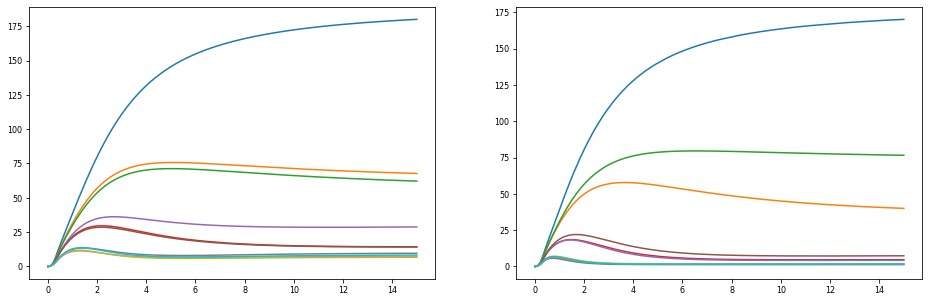

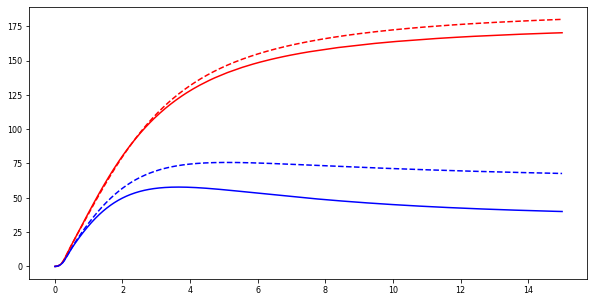

In [76]:
n_modes_plot = 10
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
_=[ax[0].plot(time_ode, photons_ode[:,i]) for i in range(0, n_modes_plot)]
_=[ax[1].plot(time_rotated, photons_rotated[:,i]) for i in range(0, n_modes_plot)]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
colors = [(1,0,0), (0,0,1)]
_=[ax.plot(time_ode, photons_ode[:,i], '--', color=colors[i]) for i in range(0, 2)]
_=[ax.plot(time_rotated, photons_rotated[:,i], '-', color=colors[i]) for i in range(0, 2)]

## Compares computation time

In [77]:
print("Time taken by ODE solver             = {0} seconds".format(t2-t1))
print("Time taken by RotatedBasisODE solver = {0} seconds".format(t4-t3))

Time taken by ODE solver             = 9.419687747955322 seconds
Time taken by RotatedBasisODE solver = 6.2773847579956055 seconds


Most of the computation time in the RotatedBasisODE solver is taken to calculate the projectors onto the new molecular basis. 

Next, we change the pump power in the cavity object and re-integrate the equations of motion using the same solver objects instantiated before.

The projectors do not need to be recalculated, since the g matrix did not change, so we can use the same Solver object. 

With the projectors already calculated, we can truly appretiate the higher numerical efficiency of the RotatedBasisODE solver, at least at a first order approximation order

In [78]:
pump_power = 2*5e2
pump = pump_power * (pump/np.sum(pump))
cavity.set_reservoir_pump_rates(rates=np.reshape(pump, [pump.shape[0]*pump.shape[1]]))

t1 = time.time()
solved_cavity_ode = solver_ode.solve()
t2 = time.time()

t3 = time.time()
solved_cavity_ode_rotated = solver_ode_rotated.solve()
t4 = time.time()

print("Time taken by ODE solver             = {0} seconds".format(t2-t1))
print("Time taken by RotatedBasisODE solver = {0} seconds".format(t4-t3))

***
A future release will implement the ability to defined non-zero initial conditions
***
Time taken by ODE solver             = 19.156782388687134 seconds
Time taken by RotatedBasisODE solver = 1.9489612579345703 seconds
